In [1]:
# Idalia_radial_model_data_comp
import os
import pickle
from datetime import datetime, timezone
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

import matplotlib.colors
import matplotlib.cm as cm

import numpy as np

import xarray as xr
import xroms
import matplotlib.pyplot as plt
from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf
from wavespectra.input.swan import read_swans

%run -i wave_stats.py
%run -i spec_plot_funcs.py

DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP_Idalia/'
DATA_FILENAME = 'hurricane_idalia_drifter_data_v2.pickle'

MODEL_DIRECTORY = '/proj/usgs-share/Projects/Idalia2023/run1/2dspec/'
FIG_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP_Idalia/figs/'

#### Import Hurricane Track

In [2]:
import geopandas as gpd
import cartopy.crs as crs
import cartopy.feature as cf
gd1 = gpd.read_file(DATA_DIRECTORY+'track/AL102023_pts.shp')
lt1 = gd1.LAT
ln1 = gd1.LON
hurpth = np.array(list(zip(ln1,lt1)))

#### Load drifter data and assign nicknames

In [3]:
with open(os.path.join(DATA_DIRECTORY, DATA_FILENAME), 'rb') as handle:
    drifters = pickle.load(handle)

drifter_types = ['spotter', 'dwsd', 'microswift']
pfx = ['S', 'D', 'M']
# `drifters` is a python dictionary keyed by drifter type (spotter,
# dwsd, or microswift)
# `spotter` is a python dictionary of Pandas DataFrames, keyed by
# each drifter ID. The drifter ids can then be accessed as follows:
spotter = drifters['spotter']
spotter_ids = list(spotter.keys())

dwsd = drifters['dwsd']
dwsd_ids = list(dwsd.keys())
    
mswift = drifters['microswift']
mswift_ids = list(mswift.keys())

# Make nicknames for these drifters to conform with the max. 8 char limit in SWAN filesname
# after adding three characters for a counter (to differentiate the POINTS).
snames=['S025D','S052D','S055D','S061D','S066D','S095D','S101D','S102D','S103D','S164D',
    'D9690','D1280','D3160', 'D3730','D0060','D0070','D0090','D0250','D8160','D9490','D8010',
    'M0029','M0037','M0046','M0048']

icount=0
for dtype in drifter_types:
    drifter_data = drifters[dtype]
    for id in list(drifter_data.keys()):
        print(id, snames[icount])
        icount += 1

SPOT-30025D S025D
SPOT-30052D S052D
SPOT-30055D S055D
SPOT-30061D S061D
SPOT-30066D S066D
SPOT-30095D S095D
SPOT-30101D S101D
SPOT-30102D S102D
SPOT-30103D S103D
SPOT-30164D S164D
300534060649690 D9690
300534060941280 D1280
300534064703160 D3160
300534064703730 D3730
300534064800060 D0060
300534064800070 D0070
300534064800090 D0090
300534064800250 D0250
300534061518160 D8160
300534060949490 D9490
300534061518010 D8010
029 M0029
037 M0037
046 M0046
048 M0048


In [4]:
# # convert the timestamp to a datetime object in the local timezone
# dt_object = datetime.fromtimestamp(index)

# # print the datetime object and its type
# print("dt_object =", dt_object)
# print("type(dt_object) =", type(dt_object))
# type(index)

In [5]:
# POINTS 'S052D018' -85.1376 29.4012
# SPECOUT 'S052D018' SPEC2D ABS 'S052D018.spc2d' OUTPUT 20230830.0608 1000 HR
# POINTS 'S052D024' -85.2961 29.3265
# SPECOUT 'S052D024' SPEC2D ABS 'S052D024.spc2d' OUTPUT 20230830.1208 1000 HR
drifter_types

['spotter', 'dwsd', 'microswift']

In [ ]:
drifter_data[id]

/proj/usgs-share/Projects/Idalia2023/run1/2dspec/S052D024.spc2d
latitude                                                            29.32647
longitude                                                          -85.29612
significant_height                                                     3.229
peak_period                                                            8.533
peak_direction                                                       108.415
peak_directional_spread                                            26.728695
mean_period                                                         6.596767
mean_direction                                                     59.258097
mean_directional_spread                                            63.077403
frequency                  [0.0293, 0.03906, 0.04883, 0.05859, 0.06836, 0...
energy_density             [0.00750592, 0.01000448, 0.015001599999999999,...
a1                         [0.094819, 0.051808, 0.047898, 0.048876, 0.003...
b1          

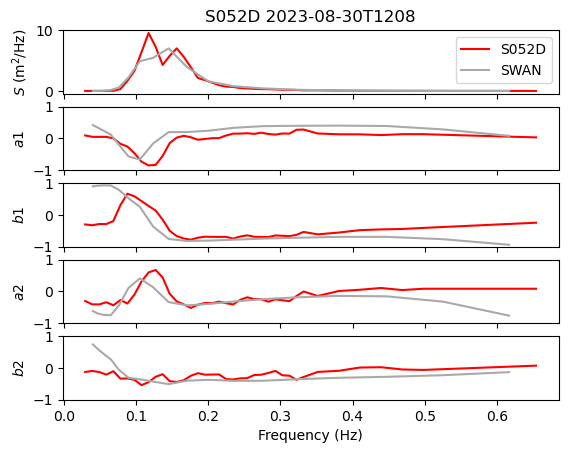

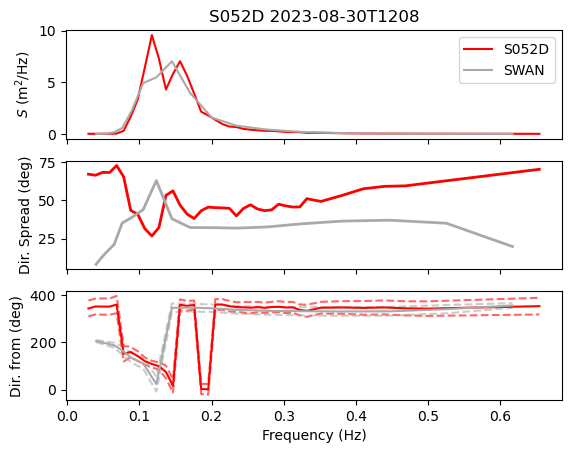

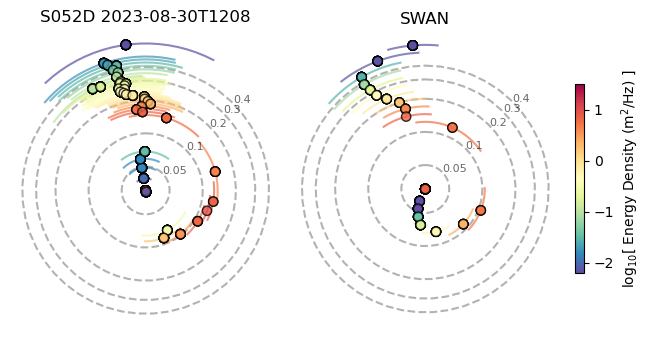

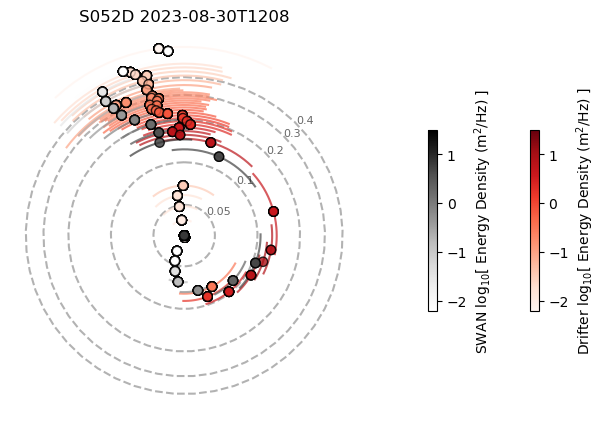

In [41]:
# Create the SWAN output file names, read SWAN model data, and populate bulk statistics arrays

dt = []
time = []
did = []
lat= []
lon= []
hsmod = []
hsobs = []
tpmod = []
tpobs = []
mdirobs  = []
mdirsobs = []
mdirmod  = []
mdirsmod = []


# start_time = '2023-08-30 05:33'
# end_time = '2023-08-30 06:25'
# ipt = 18 # for spotters and microswifts

start_time = '2023-08-30 11:33'
end_time = '2023-08-30 12:25'
ipts = [24, 24, 24, 24, 24, 24, 24, 24, 22 ]
ipt = 22 # for spotters and microswifts

# ipt = corresponding POINT for drifters
# need a non-manual way of getting these

dtypes = ['spotter', 'dwsd', 'microswift']
dtype = drifter_types[0]

ik=0
ids = ['SPOT-30052D', 'SPOT-30164D','SPOT-30101D','SPOT-30102D','SPOT-30103D',
      '029','037','046','048']
id = ids[ik]
sname_list = ['S052D','S164D','S101D','S102D','S103D','M0029','M0037','M0046','M0048']
sname = sname_list[ik]
ipt = ipts[ik]

drifter_data = drifters[dtype]
# Some rows have times with other data but no wave info (Spotters only)
only_waves = drifter_data[id]['energy_density'].notnull()

fn = "{}{:03d}.spc2d".format( sname, ipt)
pathname = os.path.join(MODEL_DIRECTORY, fn)
print(pathname)
for index, row in drifter_data[id][only_waves].loc[start_time:end_time].iterrows():
    fn = "{}{:03d}.spc2d".format( sname, ipt)
    pathname = os.path.join(MODEL_DIRECTORY, fn)
    print(row)
    if Path(pathname).is_file():
        # drifter obs
        print( index, pathname )
        did = sname
        dt = index
        time = index.strftime('%Y-%m-%dT%H%m')
        ts = sname+' '+time
        titles = [sname+' '+time, 'SWAN']
        print(titles)
        figname_base = sname+'_'+time
        print(figname_base)
        lat = ( row['latitude'] )
        lon =( row['longitude'] )
        print(dt)
        print('lon, lat:',lon,lat)
        hsobs = ( row['significant_height'] )
        tpobs = ( row['peak_period'] )
        mdirobs = ( row['mean_direction'] )
        mdirsobs =( row['mean_directional_spread'] )
        f = row['frequency']
        S = row['energy_density']
        a1 = row['a1']
        b1 = row['b1']
        a2 = row['a2']
        b2 = row['b2']
        # bulk parameters from f, S, a1, b1, etc.
        sigf =( calc_sigmaf_1d( S, f ) )
        sprd1 = ( calc_spread1_a1b1( a1, b1 ) )
        dm = calc_dirmf_a1b1( a1, b1)+180.
        dm[dm>=360]=dm[dm>=360]-360.

        # model output
        df = read_swan( pathname )
        hsmod =( np.squeeze( df.efth.spec.hs().values ) )
        tpmod = ( np.squeeze( df.efth.spec.tp().values ) )
        mdirmod =  np.squeeze( df.efth.spec.dpm().values ) 
        mdirsmod = np.squeeze( df.efth.spec.dspr().values ) 

        fs = df['freq'].values
        dirs = df['dir'].values
        # # flip the directions, so now directions are where waves come from
        dirs = dirs+180
        dirs[dirs>=360.]=dirs[dirs>=360.]-360.

        directional_bin_width_deg = dirs[2]-dirs[1]
        dirs_r = (np.pi/180.)*dirs
        spec2d = np.squeeze( df.efth.values ) 

        # This routine is from Isabel with a1 and b2 switched, and sign of a2 reversed.
        Ss, b1s, a2s, a1s, b2s = to_Fourier( spec2d, fs, dirs_r, directional_bin_width_deg, faxis=0, daxis=1 )
        a2s = -a2s

        # Almost no energy in high frequencies, so truncate
        igood = np.argwhere(Ss>1.e-8)
        fs = np.squeeze(fs[igood])
        Ss = np.squeeze(Ss[igood])
        a1s = np.squeeze(a1s[igood])
        a2s = np.squeeze(a2s[igood])
        b1s = np.squeeze(b1s[igood])
        b2s = np.squeeze(b2s[igood])

        # statistics for SWAN
        sprd1s = calc_spread1_a1b1( a1s, b1s )
        dms = calc_dirmf_a1b1( a1s, b1s)+180
        Hss = calc_Hs_1d( Ss, fs)
        print('SWAN Hs', hsmod, Hss, 'Hsobs: ', hsobs)
        
        # a1, b1, etc. plot
        fig, ax = plt.subplots( 5, 1, sharex=True )
        ax[0].plot(f, S, label=sname, c='red')
        ax[0].plot(fs, Ss, label='SWAN', c='darkgray')
        ax[0].set_ylabel(r'$S$ (m$^2$/Hz)')
        ax[0].set_title(ts)
        ax[1].plot(f, a1, c='red')
        ax[1].plot(fs, a1s, c='darkgray')
        ax[1].set_ylabel(r'$a1$')
        ax[1].set_ylim(-1,1)
        ax[2].plot(f, b1,c='red')
        ax[2].plot(fs, b1s, c='darkgray')
        ax[2].set_ylabel(r'$b1$')
        ax[2].set_ylim(-1,1)
        ax[3].plot(f, a2, c='red')
        ax[3].plot(fs, a2s, c='darkgray')
        ax[3].set_ylabel(r'$a2$')
        ax[3].set_ylim(-1,1)
        ax[4].plot(f, b2, c='red')
        ax[4].plot(fs, b2s, c='darkgray')
        ax[4].set_ylabel(r'$b2$')
        ax[4].set_ylim(-1,1)
        ax[0].legend()
        ax[4].set_xlabel('Frequency (Hz)')
        figname = FIG_DIRECTORY+figname_base+'_a1b1.png'
        plt.savefig(figname, dpi=200, bbox_inches='tight')

        # plot directions
        fig, ax = plt.subplots( 3, 1, sharex=True )
        ax[0].plot(f, S, label=sname, c='red')
        ax[0].plot(fs, Ss, label='SWAN', c='darkgray' )
        ax[0].set_ylabel(r'$S$ (m$^2$/Hz)', fontsize=10)
        ax[0].set_title(ts)
        ax[1].plot(f, sprd1, c='red', zorder=0, linewidth=2)
        ax[1].plot(fs, sprd1s, c='darkgray', zorder=0, linewidth=2)
        ax[1].set_ylabel('Dir. Spread (deg)', fontsize=10)
        ax[2].plot(f,dm+0.5*sprd1,'--', c='red', alpha=0.6, zorder=0)
        ax[2].plot(f,dm-0.5*sprd1,'--', c='red', alpha=0.6, zorder=0)
        ax[2].plot(fs,dms+0.5*sprd1s,'--', c='darkgray', alpha=0.6, zorder=0)
        ax[2].plot(fs,dms-0.5*sprd1s,'--', c='darkgray', alpha=0.6, zorder=0) 
        ax[2].plot(f,dm, c='red')
        ax[2].plot(fs,dms, c='darkgray')
        ax[2].set_ylabel('Dir. from (deg)', fontsize=10)
        ax[2].set_xlabel('Frequency (Hz)')
        ax[0].legend()
        figname = FIG_DIRECTORY+figname_base+'_dirplot.png'
        plt.savefig(figname, dpi=200, bbox_inches='tight')
        
        cmap = cm.Spectral_r
        plt_2spread(ax, 0., 0., f, np.log10(S), dm, sprd1, 
                        fs, np.log10(Ss), dms, sprd1s,
                        sf=2., ps = 45, fc=1./33., 
                        sfr=1., ec='black', cmap=cmap, cbar=True, titles=titles)
        figname = FIG_DIRECTORY+figname_base+'_2radial.png'
        plt.savefig(figname, dpi=200, bbox_inches='tight')

        plt_overlay_spread(ax, 0, 0, f, np.log10(S), dm, sprd1, 
                        fs, np.log10(Ss), dms, sprd1s,
                        sf=2., ps = 45, fc=1./33., 
                       sfr=1., ec='black', cmap=cmap, cbar=True, title=titles[0])
        figname = FIG_DIRECTORY+figname_base+'_olay_radial.png'
        plt.savefig(figname, dpi=200, bbox_inches='tight')